last edited by Claire Valva on July 6, 2019

# Synthetic Wave Stats

This file uses linear rossby wave theory to create physically motivated (yet synthetic) statistics.

In [17]:
# import packages
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import pickle
import matplotlib.colors as colors
from seaborn import cubehelix_palette #for contour plot colors
import seaborn as sns
import numpy.ma as ma
from scipy import optimize
from matplotlib import ticker, cm
import random
import numba

In [2]:
#load old spectra
file_pickle = open("spectra_02_36.0Sarr.pickle", "rb")
d2_touse, d2_seasons, d2_averages = pickle.load(file_pickle,  encoding='latin1')

In [3]:
def solve_f(X, solution):
    #function to solve f coeff equation for trend analysis
    x,y = X
    f = x*np.exp(1j*y) - solution
    return [np.real(f), np.imag(f)] 

def real_f(X, solution):
    #function to wrap solve_f so that it can be used with fsolve
    x,y = X
    z = [x+0j,y+0j]
    actual_f = solve_f(z, solution)
    return(actual_f)

# solve for phase
def root_find(sol):
    return optimize.root(real_f, [np.real(sol), 0], args=sol).x

In [4]:
## need to solve for amplitude and phase!!
touse = d2_touse[2:14][::4]
rooted = np.array([[[root_find(entry) for entry in row] for row in season] for season in touse])

In [5]:
amps = np.average(rooted[:,:,:,0], axis = 0)

### set constants 
(and check if they are correct)

In [6]:
# choose sample L_x?
samp_k = (2*np.pi) / (16000*1000)
print("k is about", samp_k)

samp_l = (((2*np.pi) / (12000*1000)) ** 2 - samp_k*samp_k)**.5
print("l is about", samp_l)

samp_Ly = (2*np.pi) / samp_l
print("Ly is about", samp_Ly)

k is about 3.9269908169872417e-07
l is about 3.4632803675275334e-07
Ly is about 18142294.70444291


In [7]:
# set constants, everything should be in meters,
# these are still a little weird, should look into them
u = 20 
B = 2e-11
Lx = 16000*1000
Ly = 18000*1000

### write some nice functions

In [8]:
#write functions to get wavenumbers and frequency
def get_k(n):
    return (2*np.pi*n)/Lx

def get_l(m):
    return (np.pi*m)/Ly

def get_omega(kn,lm):
    # from dispersion relation
    k = get_k(kn)
    lll = get_l(lm)
    uk = u*k
    
    if k == 0 and lll == 0:
        return 0
    else:
    
        frac = (B*k) / (k*k + lll*lll)
        
        return uk - frac


In [49]:
#functions that take wavenumbers,frequencies,times to distributions
def get_akl(kentry, llen):
    kks = np.abs(amps[kentry,1])
    ldiv = 1 + llen
    return kks / ldiv

def psi_comp(omega,k,l,t,x,y,Akl = 1):
    #using streamfunction equation
    
    e = np.exp(1j*(k*x - omega*t))
    sly = np.sin(l*y)
    
    return Akl*e*sly

trand = [[random.randint(1,1e15) for n in nrange] for m in mrange]
    
arruse = np.array([[get_omega(n,m), get_k(n), get_l(m), trand[m][n], get_akl(n,m)]
          for n in range(11) for m in range(5)])
    
def psi(x,y,t):
    
    arr = psi_comp(arruse[:,0],arruse[:,1],arruse[:,2],t + arruse[:,3],x,y,arruse[:,4])
    
    return np.real(np.sum(arr))

def psi_arr(xlist,ylist,tsteps):
    #gets psi for the channel at each timestep
    global trand
    trand = [[random.randint(1,1e15) for n in nrange] for m in mrange]
    
    
    tot_arr = [[[psi(xlist[xx], ylist[yy], tsteps[tt]) 
               for xx in range(len(xlist))] 
               for yy in range(len(ylist))]
               for tt in range(len(tsteps))]
    
    return np.array(tot_arr)

ValueError: operands could not be broadcast together with shapes (4,) (55,) 

In [50]:
ylist = [1,2,3,4,5]
xlist = [10,20,30,40]
tsteps = [1,2,3,5]

In [44]:
heythere = 3
def changeit(n):
    global heythere
    heythere = n
    

In [45]:
changeit(2)
heythere

2

In [ ]:
def psi(x,y,t,trand):
    
    
    arr = [psi_comp(get_omega(n,m),get_k(n),get_l(m),t + trand[m][n],x,y,get_akl(n,m)) 
           for n in range(11) 
           for m in range(5)]

need to figure out some way to generate $A_{kl}$.. what should it be? 
(Maybe I should match it with observational data?) or at least like scaling
should just load up one of the detrended ones and then take some approximate averages?

^^ that will work for now with something small for the y changes? and then play to see if I can get the right stuff


## see what it looks like

### get k,l,omega

In [10]:
#generate wavenumbers and stuff
nrange = range(10 + 1)
mrange = range(4 + 1)

omega_list = [[get_omega(kn,lm) for kn in nrange] for lm in mrange]

In [11]:
# this looks almost correct!!!
# need to add stuff for the stationary waves as well however!
# but also make A_kl 0,0 a thing!
# actually I think this might be ok, but will keep note to check on it laters

/home/clairev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/clairev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


<Figure size 432x288 with 0 Axes>

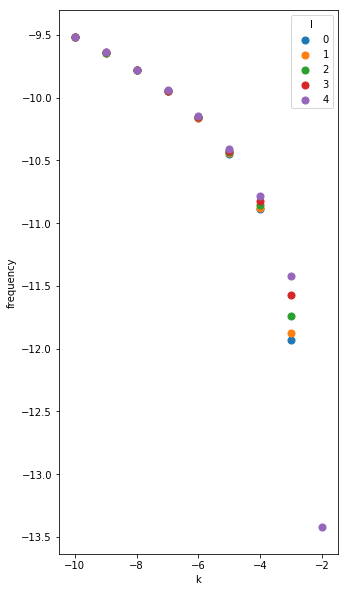

In [12]:
plt.clf()
plt.figure(figsize=(5, 10))

for xx in range(len(omega_list)):
    plt.scatter(x = np.multiply(list(nrange),-1), y = np.log(omega_list[xx]), label = list(mrange)[xx], s = 50)
    
plt.legend(title = "l")
plt.ylabel("frequency")
plt.xlabel("k")
plt.show()


<Figure size 432x288 with 0 Axes>

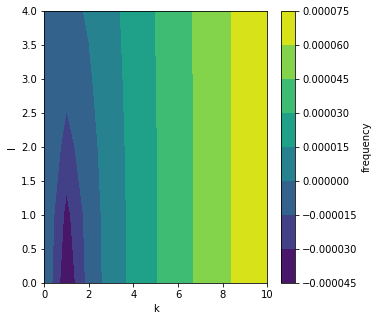

In [13]:
# plot them
plt.clf()
plt.figure(figsize=(5, 5))
plt.contourf(omega_list)
plt.ylabel("l")
plt.xlabel("k")
plt.colorbar(label = "frequency")
plt.show()

In [51]:
### lets generate about 3 months of data
secondsbump = 60*60*12
timelist = [secondsbump*j for j in range(120)]
initialt_rand = [[random.randint(1,1e15) for n in nrange] for m in mrange]

# have resolution be about 5 km by 5 km
placesx = [x*5000 for x in range(1000)]
placesy = [y*5000 for y in range(-100,100)]

In [59]:
first_psi = psi_arr(placesx,placesy,timelist)
flt_psi = first_psi.flatten()
#should probably rewrite this into something a little speedier and more pythonic

<Figure size 432x288 with 0 Axes>

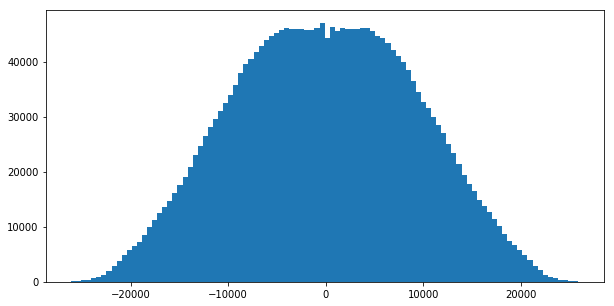

In [60]:
# plot the distribution?
# plot them
plt.clf()
plt.figure(figsize=(10,5))
plt.hist(flte, bins = 100)

plt.show()

In [53]:
#these are too big? should make this smaller and also add the random parts also?
#ahhhhhhhhhh

### add randomly correlated k and omega to psi

In [72]:
# get mean and sd of omega to choose some stuff?
omega_mean = np.average(omega_list)
omega_sd = np.std(omega_list)

samp_omegas = np.reshape(np.random.normal(omega_mean, omega_sd*2, 50), (5,10))
samp_ks = np.array(range(11,21))
samp_ls = np.array(range(5,10))

In [77]:
initialt_rand = [[random.randint(1,1e15) for n in range(25)] for m in range(15)]

In [79]:
arruse_second = [[samp_omegas[lt - 5][kt - 11], kt, lt, initialt_rand[lt][kt], get_akl(lt,kt)]
                 for lt in samp_ls for kt in samp_ks]

In [81]:
concat_arr = np.concatenate((arruse,arruse_second))

In [83]:
def second_psi(x,y,t):
    
    arr = psi_comp(concat_arr[:,0],concat_arr[:,1],
                   concat_arr[:,2],t + concat_arr[:,3],
                   x,y,concat_arr[:,4])
    
    return np.real(np.sum(arr))

def second_psi_arr(xlist,ylist,tsteps):
    #gets psi for the channel at each timestep
    global trand
    trand = [[random.randint(1,1e15) for n in nrange] for m in mrange]
    
    
    tot_arr = [[[second_psi(xlist[xx], ylist[yy], tsteps[tt]) 
               for xx in range(len(xlist))] 
               for yy in range(len(ylist))]
               for tt in range(len(tsteps))]
    
    return np.array(tot_arr)